In [14]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
NUM_FRAMES = 10
DOMAIN_RANDOMIZATION = True

In [22]:
from gymnasium.wrappers import (
    TimeLimit,
    TransformReward,
    FrameStackObservation,
    TimeAwareObservation,
)
from env_hiv import HIVPatient
from train import LatestActionWrapper


def env_builder(domain_randomization=DOMAIN_RANDOMIZATION, normalize_reward=True):
    env = HIVPatient(domain_randomization=domain_randomization)
    if normalize_reward:
        env = TransformReward(env, lambda reward: reward / 50000.0)
    env = LatestActionWrapper(env)
    env = TimeLimit(env, max_episode_steps=200)
    env = TimeAwareObservation(env)
    env = FrameStackObservation(env, NUM_FRAMES)
    return env

In [ ]:
from stable_baselines3 import PPO
import wandb
from wandb.integration.sb3 import WandbCallback

env = env_builder(domain_randomization=DOMAIN_RANDOMIZATION, normalize_reward=True)
name = "ppo_mlp_randomized"
wandb.init(project="mva-rl-assignment-Butanium", name=name, sync_tensorboard=True)
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=f"logs/{name}", device="cpu")
try:
    model.learn(total_timesteps=10000, progress_bar=True, callback=WandbCallback())
finally:
    model.save("models/ppo_hiv_all_wrappers_rdmz_training")

## Manual evaluation

In [29]:
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def test_model(model, n_eval_episodes=5):
    env = env_builder(domain_randomization=False, normalize_reward=False)
    ep_rewards_deterministic, _ = evaluate_policy(
        model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True
    )
    print(
        f"Mean reward (no randomization): {np.mean(ep_rewards_deterministic):.2e} +/- {np.std(ep_rewards_deterministic):.2e}"
    )

    rnd_env = env_builder(domain_randomization=True, normalize_reward=False)
    ep_rewards_rnd_deterministic, _ = evaluate_policy(
        model, rnd_env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True
    )
    print(
        f"Mean reward (with randomization): {np.mean(ep_rewards_rnd_deterministic):.2e} +/- {np.std(ep_rewards_rnd_deterministic):.2e}"
    )

    ep_rewards_not_deterministic, _ = evaluate_policy(
        model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True, deterministic=False
    )
    print(
        f"Mean reward (no randomization) not deterministic: {np.mean(ep_rewards_not_deterministic):.2e} +/- {np.std(ep_rewards_not_deterministic):.2e}"
    )

    ep_rewards_rnd_not_deterministic, _ = evaluate_policy(
        model,
        rnd_env,
        n_eval_episodes=n_eval_episodes,
        return_episode_rewards=True,
        deterministic=False,
    )
    print(
        f"Mean reward (with randomization) not deterministic: {np.mean(ep_rewards_rnd_not_deterministic):.2e} +/- {np.std(ep_rewards_rnd_not_deterministic):.2e}"
    )
    # 2x2 subplots with histograms of the episode rewards
    fig = make_subplots(rows=2, cols=2)
    fig.add_trace(go.Histogram(x=ep_rewards_deterministic, name="No randomization"), row=1, col=1)
    fig.add_trace(go.Histogram(x=ep_rewards_rnd_deterministic, name="With randomization"), row=1, col=2)
    fig.add_trace(
        go.Histogram(x=ep_rewards_not_deterministic, name="No randomization not deterministic"),
        row=2,
        col=1,
    )
    fig.add_trace(
        go.Histogram(x=ep_rewards_rnd_not_deterministic, name="With randomization not deterministic"),
        row=2,
        col=2,
    )
    fig.show()

c:\Users\Travail\Documents\mva\mva-rl-assignment-Butanium\.venv\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\Travail\Documents\mva\mva-rl-assignment-Butanium\.venv\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Action taken: 2, Reward received: 7808.100000000002
Action taken: 0, Reward received: 25153.433950647708
Action taken: 1, Reward received: 25074.952834907534
Action taken: 1, Reward received: 26210.550910345428
Action taken: 2, Reward received: 17540.23835598585
Action taken: 0, Reward received: 30828.41191394606
Action taken: 2, Reward received: 11791.550057180044
Action taken: 3, Reward received: 16617.381185512862
Action taken: 0, Reward received: 34280.690622839225
Action taken: 2, Reward received: 15535.532192608596
Action taken: 2, Reward received: 20691.143920580307
Action taken: 3, Reward received: 21981.559643609147
Action taken: 2, Reward received: 32177.423649555836
Action taken: 1, Reward received: 52508.01264669672
Action taken: 2, Reward received: 50250.51162622642
Action taken: 2, Reward received: 48580.626446084905
Action taken: 0, Reward received: 60262.64332386263
Action taken: 2, Reward received: 19385.86614644558
Action taken: 2, Reward received: 35134.7296933835
Ac

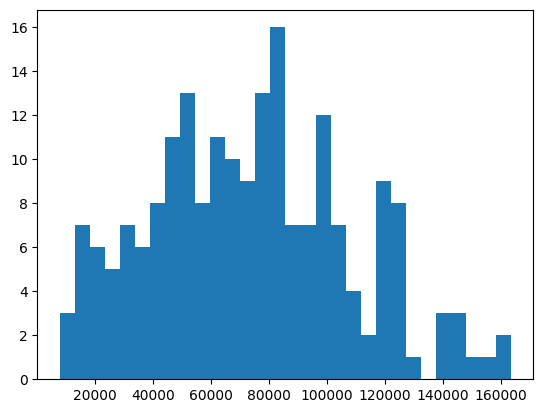

In [25]:
env = env_builder(domain_randomization=False, normalize_reward=False)
obs, _ = env.reset()
done = False
truncated = False
total_reward = 0
all_rewards = []
while not done and not truncated:
    action = model.predict(obs, deterministic=False)[0]
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    all_rewards.append(reward)
    print(f"Action taken: {action}, Reward received: {reward}")

print(f"Total reward: {total_reward}")
import matplotlib.pyplot as plt
plt.hist(all_rewards, bins=30)  # Increased the number of bins for better granularity
plt.show()

In [30]:
test_model(model, n_eval_episodes=10)

c:\Users\Travail\Documents\mva\mva-rl-assignment-Butanium\.venv\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning:

WARN: Box low's precision lowered by casting to float32, current low.dtype=float64

c:\Users\Travail\Documents\mva\mva-rl-assignment-Butanium\.venv\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning:

WARN: Box high's precision lowered by casting to float32, current high.dtype=float64

c:\Users\Travail\Documents\mva\mva-rl-assignment-Butanium\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Mean reward (no randomization): 3.21e+06 +/- 0.00e+00
Mean reward (with randomization): 4.32e+06 +/- 1.46e+06
Mean reward (no randomization) not deterministic: 1.64e+07 +/- 4.01e+06
Mean reward (with randomization) not deterministic: 1.42e+07 +/- 3.86e+06
